In [200]:
"""Image warping based on a disparity"""
%matplotlib inline
import os
import math

import h5py
from PIL import Image
import numpy as np
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def valid_pixel(pixel, img_size):
    """Returns true if the pixel co-ordinate lies inside the image grid"""
    size_x, size_y = img_size
    valid = (((pixel[0] > -1) and (pixel[0] < size_x)) and
             ((pixel[1] > -1) and (pixel[1] < size_y)))
    return valid

#TODO consider keeping pixels around so don't have to make it multiple times
def fw_warp_image(ref_view, disparity_map, ref_pos, novel_pos, dtype=np.uint8, blank=0):
    """
    Returns a forward warped novel from an input image and disparity_map
    For each pixel position in the reference view, shift it by the disparity,
    and assign the value in the reference at that new pixel position to the
    novel view.

    Keyword arguments:
    ref_view -- colour image data at the reference position
    disparity_map -- a disparity map at the reference position
    ref_pos -- the grid co-ordinates of the ref_view
    novel_pos -- the target grid position for the novel view
    """
    size_x, size_y = ref_view.shape[0:2]
    distance = ref_pos - novel_pos

    #Initialise an array of blanks
    novel_view = np.full(ref_view.shape, blank, dtype=dtype)

    #Create an array of pixel positions
    grid = np.meshgrid(np.arange(size_x), np.arange(size_y), indexing='ij')
    stacked = np.stack(grid, 2)
    pixels = stacked.reshape(-1, 2)

    #Repeat the elements of the disparity_map to match the distance
    repeated = np.repeat(disparity_map, 2, -1).reshape((size_x * size_y, 2))

    #Round to the nearest integer value
    result = (repeated * distance).astype(int)
    novel_pixels = pixels + result
    
    #Move the pixels from the reference view to the novel view
    for novel_coord, ref_coord in zip(novel_pixels, pixels):
        if valid_pixel(novel_coord, ref_view.shape[0:2]):
            novel_view[novel_coord[0], novel_coord[1]] = (
                ref_view[ref_coord[0], ref_coord[1]])

    return novel_view

def slow_fw_warp_image(ref_view, disparity_map, ref_pos, novel_pos, dtype=np.uint8, blank=0):
    """
    Returns a forward warped novel from an input image and disparity_map
    For each pixel position in the reference view, shift it by the disparity,
    and assign the value in the reference at that new pixel position to the
    novel view.
    Has a very large for loop, performance should be compared with
    fw_warp_image

    Keyword arguments:
    ref_view -- colour image data at the reference position
    disparity_map -- a disparity map at the reference position
    ref_pos -- the grid co-ordinates of the ref_view
    novel_pos -- the target grid position for the novel view
    """
    size_x, size_y = ref_view.shape[0:2]
    distance = ref_pos - novel_pos
    
    #Initialise an array full of blanks
    novel_view = np.full(ref_view.shape, blank, dtype=dtype)
    for x in range(size_x):
        for y in range(size_y):
            res = np.repeat(disparity_map[x, y], 2, -1) * distance
            new_pixel = ((x, y) + res).astype(int)
            if valid_pixel(new_pixel, (size_x, size_y)):
                novel_view[new_pixel[0], new_pixel[1]] = ref_view[x, y]

def save_array_as_image(array, save_location):
    """Saves an array as an image at the save_location using pillow"""
    image = Image.fromarray(array)
    image.save(save_location)
    image.close()

def get_diff_image(im1, im2):
    diff = np.subtract(im1.astype(float), im2.astype(float))
    diff = abs(diff).astype(np.uint8)
    return diff

In [201]:
#Data transform code
"""Contains data transforms which can be passed to the data loader"""
def disparity_based_rendering(disparities, views, grid_size, dtype=np.uint8, blank=0):
    """Returns a list of warped images using the input views and disparites"""
     # Alternatively, grid_one_way - 1 can be used below
    shape = (grid_size,) + views.shape[-3:]
    warped_images = np.empty(
        shape=shape, dtype=dtype)
    grid_one_way = int(math.sqrt(grid_size))
    sample_index = grid_size // 2 + (grid_one_way // 2)
    for i in range(grid_one_way):
        for j in range(grid_one_way):
            res = fw_warp_image(
                ref_view=views[sample_index, ...],
                disparity_map=disparities[sample_index, ...],
                ref_pos=np.asarray([grid_one_way // 2, grid_one_way // 2]),
                novel_pos=np.asarray([i, j]),
                dtype=dtype,
                blank=blank
            )
            warped_images[i * grid_one_way + j] = res
    return warped_images

def disparity_based_rendering_slow(disparities, views, grid_size, dtype=np.uint8, blank=0):
    """Returns a list of warped images using the input views and disparites"""
     # Alternatively, grid_one_way - 1 can be used below
    shape = (grid_size,) + views.shape[-3:]
    warped_images = np.empty(
        shape=shape, dtype=dtype)
    grid_one_way = int(math.sqrt(grid_size))
    sample_index = grid_size // 2 + (grid_one_way // 2)
    for i in range(grid_one_way):
        for j in range(grid_one_way):
            res = slow_fw_warp_image(
                ref_view=views[sample_index, ...],
                disparity_map=disparities[sample_index, ...],
                ref_pos=np.asarray([grid_one_way // 2, grid_one_way // 2]),
                novel_pos=np.asarray([i, j]),
                dtype=dtype,
                blank=blank
            )
            warped_images[i * grid_one_way + j] = res
    return warped_images

def transform_to_warped(sample):
    """
    Input a dictionary of depth images and reference views,
    Output a dictionary of inputs -warped and targets - reference
    """
    normalise_sample(sample)
    disparity = sample['depth']
    targets = sample['colour']
    grid_size = sample['grid_size']
    %time disparity_based_rendering(disparity.numpy(), targets.numpy(), grid_size, dtype=np.float32, blank=-1.0)
    %time disparity_based_rendering_slow(disparity.numpy(), targets.numpy(), grid_size, dtype=np.float32, blank=-1.0)
    
    warped_images = disparity_based_rendering(
        disparity.numpy(), targets.numpy(), grid_size, dtype=np.float32, blank=-1.0)
    
    inputs = torch.from_numpy(warped_images).float()
    return {'inputs': inputs, 'targets': targets}

def normalise_lf(lf):
    maximum = 255.0
    ((lf.div_(maximum)).mul_(2.0)).add_(-1.0)

def normalise_sample(sample):
    """Coverts an lf in the range 0 to maximum into -1 1"""
    lf = sample['colour']
    normalise_lf(lf)
    return sample

def upper_left_patch(sample):
    width = sample['colour'].shape[2]
    sample['colour'] = sample['colour'][:, 0:width//2, 0:width//2, :]
    sample['depth'] = sample['depth'][:, 0:width//2, 0:width//2, :]
    return sample

In [190]:
#Dataloading code
class TrainFromHdf5(data.Dataset):
    """
    Creates a training set from a hdf5 file
    """
    def __init__(self, hdf_file, patch_size, num_crops, transform=None):
        """
        Keyword arguments:
        hdf_file -- the location containing the hdf5 file
        patch_size -- the size of the patches to extract for training
        num_crops -- the number of patches to extract for training
        transform -- an optional transform to apply to the data
        """
        super()
        self.group = hdf_file['train']
        self.depth = self.group['disparity']['images']
        self.colour = self.group['colour']['images']
        self.transform = transform
        self.patch_size = patch_size
        self.num_crops = num_crops

    def __getitem__(self, index):
        """
        Return item at index in 0 to len(self)
        In this case a set of crops from an lf sample
        Return type is a dictionary of depth and colour arrays
        """
        idx = index // self.num_crops
        start_h, start_v = self.generate_random_crop()
        end_h = start_h + self.patch_size
        end_v = start_v + self.patch_size
        depth = torch.tensor(
            self.depth[idx, :, start_h:end_h, start_v:end_v, :],
            dtype=torch.float32
        )
        colour = torch.tensor(
            self.colour[idx, :, start_h:end_h, start_v:end_v, :],
            dtype=torch.float32
        )
        grid_size = self.group['colour'].attrs['shape'][1]
        sample = {'depth': depth, 'colour': colour, 'grid_size': grid_size}

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        """Return the number of samples in the dataset"""
        return self.group['colour'].attrs['shape'][0] * self.num_crops

    def generate_random_crop(self):
        """Return an array of random crops indexes from given light field"""
        pixel_end = self.group['disparity'].attrs['shape'][2]
        high = pixel_end - self.patch_size

        # An array of indexes to start patch extraction from
        # Array position [0] would contain patch [0] starting location
        crop_start_indexes = np.random.random_integers(0, high, 2)

        return crop_start_indexes

class ValFromHdf5(data.Dataset):
    """
    Creates a validation set from a hdf5 file
    """
    def __init__(self, hdf_file, transform=None):
        """
        Keyword arguments:
        hdf_file -- the location containing the hdf5 file
        transform -- an optional transform to apply to the data
        """
        super()
        self.group = hdf_file['val']
        self.depth = self.group['disparity']['images']
        self.colour = self.group['colour']['images']
        self.transform = transform

    def __getitem__(self, index):
        """
        Return item at index in 0 to len(self)
        In this case a set of crops from an lf sample
        Return type is a dictionary of depth and colour arrays
        """
        depth = torch.tensor(self.depth[index, ...], dtype=torch.float32)
        colour = torch.tensor(self.colour[index, ...], dtype=torch.float32)
        grid_size = self.group['colour'].attrs['shape'][1]
        sample = {'depth': depth, 'colour': colour, 'grid_size': grid_size}
        
        # Running out of GPU memory on validation
        sample = upper_left_patch(sample)

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        """Return the number of samples in the dataset"""
        return self.group['colour'].attrs['shape'][0]

def create_dataloaders(hdf_file, threads, patch_size, crops):
    """Creates a train and val dataloader from a h5file and a config file"""
    print("Loading dataset")
    train_set = TrainFromHdf5(
        hdf_file=hdf_file,
        patch_size=patch_size,
        num_crops=crops,
        transform=transform_to_warped)
    val_set = ValFromHdf5(
        hdf_file=hdf_file,
        transform=transform_to_warped)

    batch_size = {'train': 3, 'val': 1}
    data_loaders = {}
    for name, dset in (('train', train_set), ('val', val_set)):
        data_loaders[name] = DataLoader(
            dataset=dset, num_workers=threads,
            batch_size=batch_size[name],
            shuffle=True)

        return data_loaders

In [191]:
#Show the images

def show(img):
    npimg = img.numpy()
    transposed = np.transpose(npimg, (1,2,0))
    plt.figure(figsize = (20,20))
    plt.imshow(transposed, interpolation='nearest')

Loading dataset


/users/pgrad/martins7/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:59: DeprecationWarning: This function is deprecated. Please call randint(0, 384 + 1) instead


CPU times: user 1.86 s, sys: 0 ns, total: 1.86 s
Wall time: 1.82 s
CPU times: user 6.22 s, sys: 0 ns, total: 6.22 s
Wall time: 6.22 s


/users/pgrad/martins7/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:59: DeprecationWarning: This function is deprecated. Please call randint(0, 384 + 1) instead


CPU times: user 1.83 s, sys: 0 ns, total: 1.83 s
Wall time: 1.79 s
CPU times: user 6.27 s, sys: 0 ns, total: 6.27 s
Wall time: 6.27 s


/users/pgrad/martins7/pytorch35/lib/python3.5/site-packages/ipykernel_launcher.py:59: DeprecationWarning: This function is deprecated. Please call randint(0, 384 + 1) instead


CPU times: user 1.82 s, sys: 0 ns, total: 1.82 s
Wall time: 1.79 s
CPU times: user 6.34 s, sys: 16 ms, total: 6.35 s
Wall time: 6.31 s


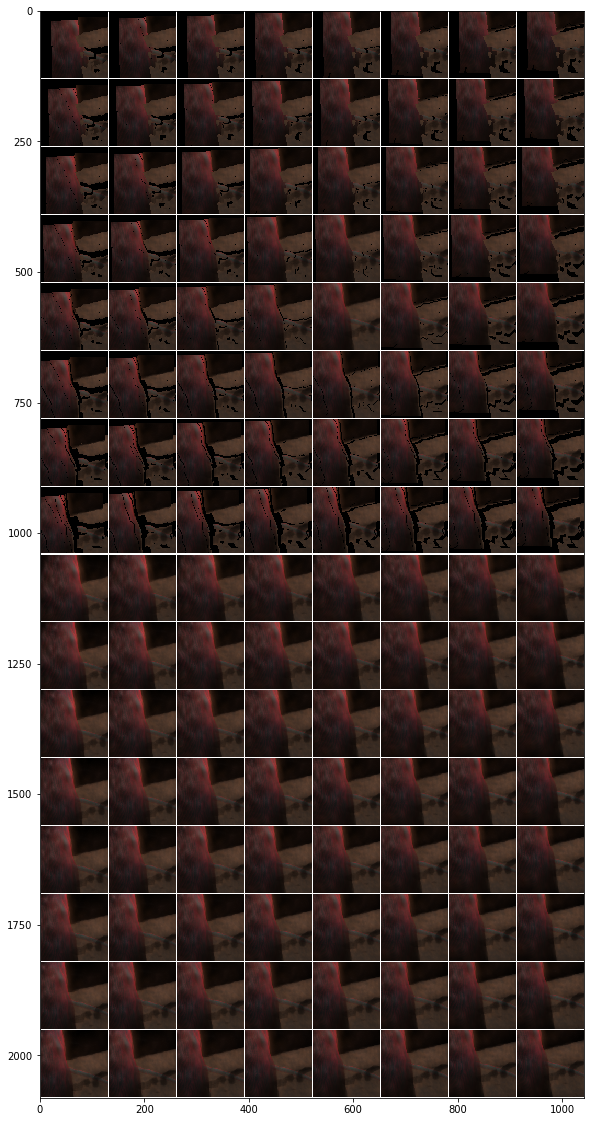

In [202]:
#Data usage code
""" The main file to run the View synthesis CNN
Many Neural Network pipeline considerations are based on
https://github.com/twtygqyy/pytorch-vdsr 
And the pytorch example files """
import time
import torchvision.utils as vutils

cuda = True

#Attempts to otimise - see 
#https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do
torch.backends.cudnn.benchmark = True

hdf5_dir = "/users/pgrad/martins7/turing/overflow-storage/lf_volume_sets"
hdf5_name = "lf_set.h5"
file_path = os.path.join(hdf5_dir,
                         hdf5_name)
with h5py.File(file_path, mode='r', libver='latest', swmr=True) as h5_file:
    data_loaders = create_dataloaders(h5_file, 0, 128, 4)
    phase = 'train'
    batch = next(iter(data_loaders[phase]))
    targets = batch['targets']
    inputs = batch['inputs']
    inputs.requires_grad_(False)
    targets.requires_grad_(False)

    if cuda:
        inputs = inputs.cuda()
        targets = targets.cuda()

    input_imgs = inputs[0, ...].transpose(1, 3)
    truth_imgs = targets[0, ...].transpose(1, 3)
    both_imgs = torch.cat((input_imgs, truth_imgs))
    input_grid = vutils.make_grid(
        input_imgs, nrow=8, range=(-1, 1), normalize=True)
    target_grid = vutils.make_grid(
        truth_imgs, nrow=8, range=(-1, 1), normalize=True)
    both_grid = vutils.make_grid(
        both_imgs, nrow=8, range=(-1, 1), normalize=True, pad_value=1)

    show(both_grid.cpu())

def reverse_tensor(tensor, dim):
    """Flips the tensor in the given dimension"""
    return torch.from_numpy(
        np.flip(tensor.cpu().numpy(), dim).copy())
    

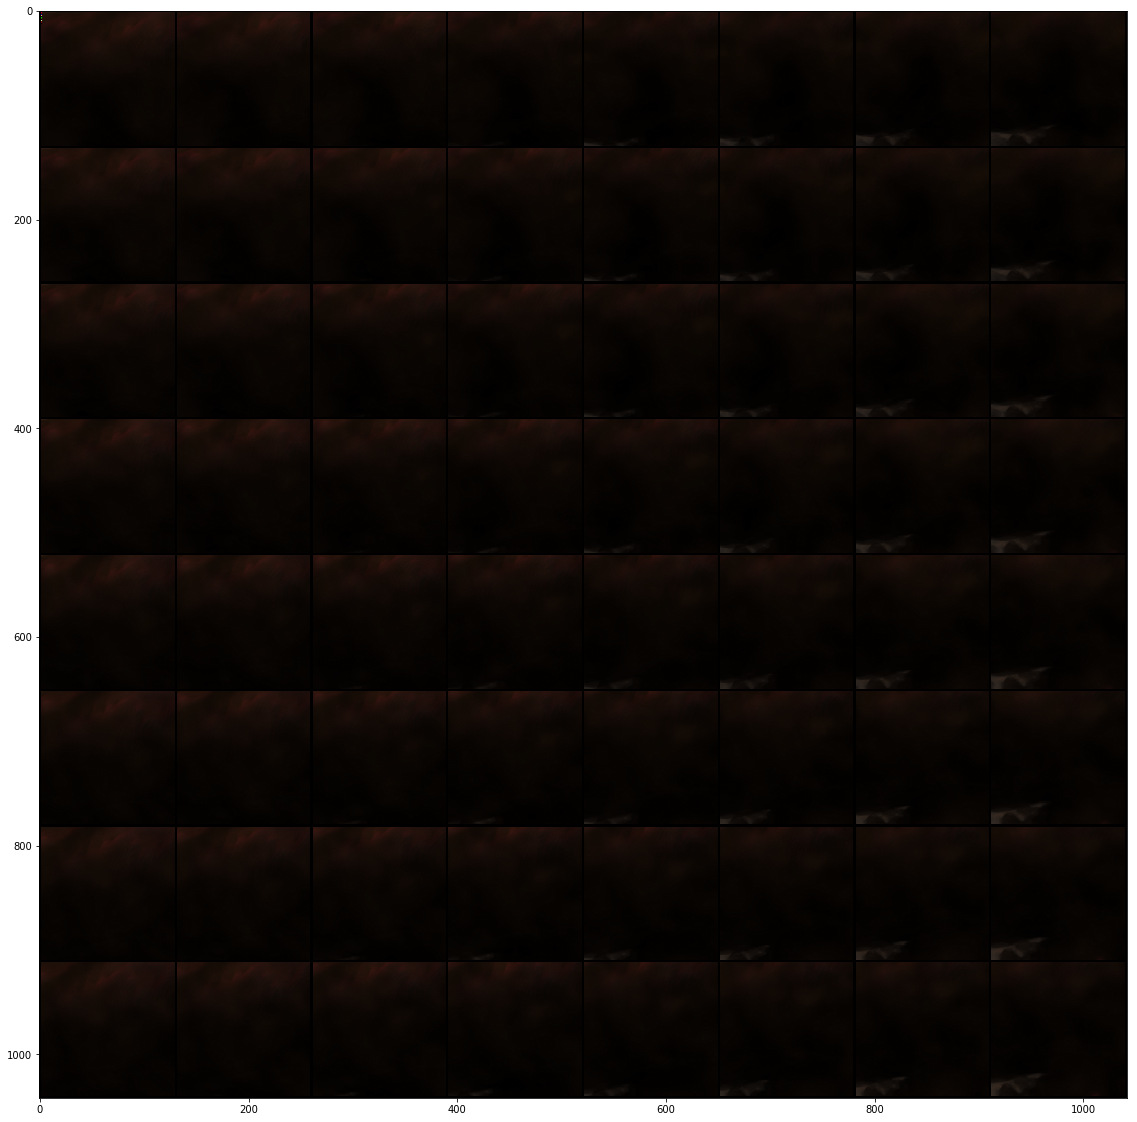

In [154]:
shape = (64, 128, 128, 3)
array = np.empty(shape=shape, dtype=np.uint8)
torch_array = torch.from_numpy(array).float()
imgs = torch_array.transpose(1, 3)

grid = vutils.make_grid(
    imgs, nrow=8, range=(-1, 1), normalize=True)
show(input_grid.cpu())